# Imports and definitions

In [1]:
from utils import *

### Base path ###
#path_shared = '/home/shared/'
path_shared = '../../shared/'

### Input ###
path_scan = path_shared + 'dataXRDXRF/MunchMuseum/M491/'
path_xrd = path_scan + 'ProfiloXRD/'          # XRD scan
filename_xrd = 'Frame0006.dat'
filename_calibration = 'calibration.ini'
#path_xrf = path_scan + 'ProfiloXRF/labels/'   # XRF scan
path_database = path_shared + 'Database/'     # tabulated phases

### Output ###
subfolder_output = 'output/MunchMuseum/M491/Profilo/'
path_figures = subfolder_output + 'figures/'          # figures generated by the script
path_phases_check = path_figures + 'phases_check/'
path_results = subfolder_output + 'results/'          # results generated by the script: raw data, tif maps

### Fit ###
min_theta = 20
max_theta = 53
min_intensity = 0.1  # among the tabulated peaks, selects only the ones above this threshold of intensity (scale between 0 and 1)
first_n_peaks = 5    # selects the first n most intense peaks (if None, leaves all the peaks)
sigma = 0.2          # sigma used in the peaks of synthetic diffraction patterns

#### To reset results, delete output folders.
WARNING: every previous result will be lost. Use only if you want to delete all files in the data folders

In [2]:
do_you_want_to_delete = False

if do_you_want_to_delete:
    for path_sel in [path_figures, path_results]:
        if isdir(path_sel):
            rmtree(path_sel)

#### Check if output folders exist. If not, create them.

In [3]:
for path_sel in [path_figures, path_results]:
    if not isdir(path_sel):
        makedirs(path_sel)

# Read phase database

In [4]:
database = DatabaseXRD().read_cifs(path_database)
print('Phases in database:', len(database))

Phases in database: 369


# Read and process XRD data

#### Parameters of the smoothing of XRD pattern
- `window_snip`: width of the window used for determining the background
- `offset_background`: value added to the background, before subtracting it from the raw signal
- `std_smooth`: degree of the final smooth applied to the XRD pattern (standard deviation of the Gaussian kernel used in the convolution)

Loading '../../shared/dataXRDXRF/MunchMuseum/M491/ProfiloXRD/Frame0006.dat'
Data length: 1280
Initial calibration:
a = -1214.7, s = 1952.7, beta = 51.663
Theta range [19.77907407899562, 53.54888119293563]


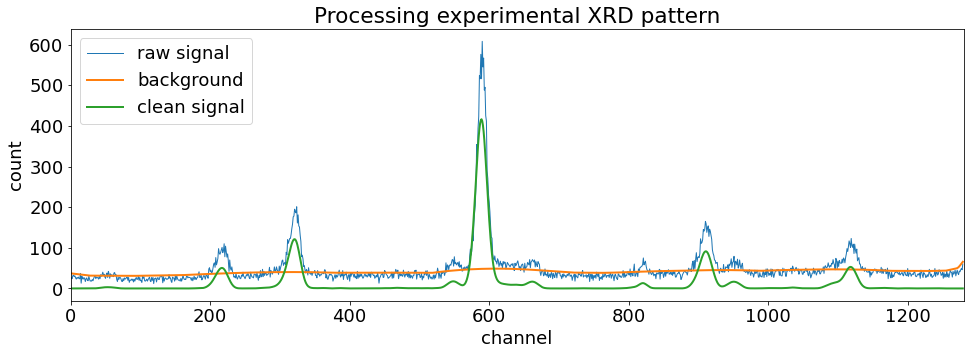

In [5]:
rcParams['font.size'] = 18

window_snip = 32         # default 32
offset_background = 10   # default 0
std_smooth = 5           # set 0 for no smooth

print(f'Loading \'{path_xrd + filename_xrd}\'')
data_channels, data_count = loadtxt(path_xrd + filename_xrd, unpack = True, dtype = 'int')
data_background = snip(convolve(data_count, n = 21, std = 3), m = window_snip)
background_shifted = data_background + offset_background
data_count_no_bg = maximum(data_count - background_shifted, 0)
data_count_smoothed = convolve(data_count_no_bg, n = ceil(3 * std_smooth + 1), std = std_smooth)
data_rescaling = data_count_smoothed.max()
data_intensity = data_count_smoothed / data_rescaling
calib = Calibration(DataXRD()).from_file(path_xrd + filename_calibration)
print(f'Data length: {data_count.shape[0]}')
print('Initial calibration:')
print(f'a = {calib.opt[0]:.1f}, s = {calib.opt[1]:.1f}, beta = {calib.opt[2]:.3f}')
print(f'Theta range {list(calib.fce([data_channels[0], data_channels[-1]], *calib.opt))}')

spectrum = FastSpectraXRD().from_components(
    opt = calib.opt.copy(),
    counts = data_count_smoothed,
    rescaling = data_rescaling,
    intensity = data_count_smoothed / nanmax(data_count_smoothed)
)

fig, ax = subplots(figsize = (16, 5))
ax.plot(data_count, lw = 1, label = 'raw signal')
ax.plot(background_shifted, lw = 2, label = 'background')
ax.plot(data_count_smoothed, lw = 2, label = 'clean signal')
ax.legend(frameon = True, loc = 2)
ax.set_xlim(0, len(data_count))
ax.set_xlabel('channel')
ax.set_ylabel('count')
ax.set_title('Processing experimental XRD pattern')
show()

# Obtain list of phases

### Search phases with given elements
- `elements_chosen`: Elements that need to be in the selected phases.
- `elements_excluded`: Elements that must not be in the selected phases.

In [6]:
elements_chosen = ['Fe']
elements_excluded = []
# DO NOT EXCLUDE: Al, Ca, Cl, P, S, Si

df_phases = DataFrame(columns = ['Name in database', 'Chemical formula', 'N. of samples'])
for phase_name, phase_set in sorted(database.items()):
    p = phase_set[0]
    if '_chemical_formula_sum' in p:
        if (all(is_element_in_formula(e, p['_chemical_formula_sum']) for e in elements_chosen)
            and all(not is_element_in_formula(e, p['_chemical_formula_sum']) for e in elements_excluded)):
            df_phases.loc[len(df_phases)] = [phase_name, p['_chemical_formula_sum'], len(phase_set)]
elements_excluded = []
df_phases

,Name in database,Chemical formula,N. of samples
0,Akaganeite,Cl0.675 Fe4 O8,2
1,Erythrite,As4 Co4.02 Fe1.48 H32 Ni0.50 O32,1
2,Fe2 O3,Fe2 O3,10
3,Fe2MnO4,Fe2 Mn O4,1
4,Goethite,Fe H O2,22
5,Hematite,Fe2 O3,13
6,Jacobsite,Al0.049 Fe1.911 Mg0.736 Mn0.284 O4 Zn0.017,4
7,Jarosite,Fe2.88 H5.83 K0.81 O13.64 S2,16
8,Lepidocrocite,Fe H O2,2
9,Magnetite,Fe3 O4,1


### Fit selected phases on experimental XRD pattern

In [7]:
list_overlap = []
list_overlap_avg = []
list_overlap_max = []
list_x_y = []

for i in range(df_phases.shape[0]):
    phase_name = df_phases['Name in database'].iloc[i]
    phase_set = database[phase_name]
    
    gs = GammaSearch([p for p in phase_set], spectrum, min_theta = min_theta, max_theta = max_theta,
        min_intensity = min_intensity, first_n_peaks = first_n_peaks, sigma = sigma)
    gs = gs.fit_cycle(gamma = True, steps = 10)
    overlap = gs.overlap3_area_ratio()
    list_overlap.append(overlap)

df_phases['Best overlap'] = [nanmax(list_overlap[i]) for i in range(df_phases.shape[0])]
df_phases.style.format({'Best overlap': '{:.3f}'})

,Name in database,Chemical formula,N. of samples,Best overlap
0,Akaganeite,Cl0.675 Fe4 O8,2,0.084
1,Erythrite,As4 Co4.02 Fe1.48 H32 Ni0.50 O32,1,0.032
2,Fe2 O3,Fe2 O3,10,0.339
3,Fe2MnO4,Fe2 Mn O4,1,0.041
4,Goethite,Fe H O2,22,0.439
5,Hematite,Fe2 O3,13,0.149
6,Jacobsite,Al0.049 Fe1.911 Mg0.736 Mn0.284 O4 Zn0.017,4,0.104
7,Jarosite,Fe2.88 H5.83 K0.81 O13.64 S2,16,0.053
8,Lepidocrocite,Fe H O2,2,0.130
9,Magnetite,Fe3 O4,1,0.001


### Select phase samples as primary or secondary phases
- `thresholds_overlap_avg`. If avg overlap of a phase is above the second threshold, the phase can be selected as primary. Otherwise, if avg overlap is above the first threshold, the phase can be selected as secondary.

##### Note
If a phase is selected as primary, it is prevented from being selected as secondary, even with a different sample.

In [8]:
thresholds_overlap = [0.1, 0.3]

list_sel_category = []
list_sel_name = []
list_sel_formula = []
list_sel_sample = []
list_sel_overlap = []

for i in range(df_phases.shape[0]):
    idx = (list_overlap[i] >= thresholds_overlap[1])
    if any(idx):
        arr_sample_filtered = arange(df_phases.loc[i, 'N. of samples'])[idx]
        arr_overlap_filtered = list_overlap[i][idx]
        j = nanargmax(arr_overlap_filtered)
        
        list_sel_category.append('Primary')
        list_sel_name.append(df_phases.loc[i, 'Name in database'])
        list_sel_formula.append(df_phases.loc[i, 'Chemical formula'])
        list_sel_sample.append(arr_sample_filtered[j])
        list_sel_overlap.append(arr_overlap_filtered[j])
    else:
        idx = (list_overlap[i] >= thresholds_overlap[0])
        if any(idx):
            arr_sample_filtered = arange(df_phases.loc[i, 'N. of samples'])[idx]
            arr_overlap_filtered = list_overlap[i][idx]
            j = nanargmax(arr_overlap_filtered)

            list_sel_category.append('Secondary')
            list_sel_name.append(df_phases.loc[i, 'Name in database'])
            list_sel_formula.append(df_phases.loc[i, 'Chemical formula'])
            list_sel_sample.append(arr_sample_filtered[j])
            list_sel_overlap.append(arr_overlap_filtered[j])

df_phases_sel = DataFrame({
    'Category': list_sel_category,
    'Phase': list_sel_name,
    'Formula': list_sel_formula,
    'Sample': list_sel_sample,
    'Overlap': list_sel_overlap,
})
df_phases_sel = df_phases_sel.sort_values(by = ['Category', 'Phase']).reset_index(drop = True)
df_phases_sel.style.format({'Overlap': '{:.3f}'})

,Category,Phase,Formula,Sample,Overlap
0,Primary,Fe2 O3,Fe2 O3,1,0.339
1,Primary,Goethite,Fe H O2,11,0.439
2,Primary,Siderite,C Fe O3,1,0.390
3,Secondary,Hematite,Fe2 O3,9,0.149
4,Secondary,Jacobsite,Al0.049 Fe1.911 Mg0.736 Mn0.284 O4 Zn0.017,1,0.104
5,Secondary,Lepidocrocite,Fe H O2,0,0.130
6,Secondary,Pyrite,Fe S2,2,0.136


### Add selected phases to their appropriate files

This cell writes the list of names of selected phases into the files `phases_selection_primary.dat` and `phases_selection_secondary.dat`. If the files do not exist, the cell creates them.

In [9]:
for category in ['Primary', 'Secondary']:
    filename = f'{subfolder_output}phases_selection_{category.lower()}.dat'
    df_phases_sel.loc[df_phases_sel['Category'] == category, ['Phase', 'Formula', 'Sample', 'Overlap']]\
    .to_csv(filename, header = False, index = False, mode = 'a', float_format = '%.3f')

### Delete the files with list of selected phases
Delete the files `phases_selection_primary.dat` and `phases_selection_secondary.dat`.

In [10]:
do_you_want_to_delete = False

if do_you_want_to_delete:
    for file_name in ['phases_selection_primary.dat', 'phases_selection_secondary.dat']:
        if exists(subfolder_output + file_name):
            remove(subfolder_output + file_name)

# Check phases

### Specific phases vs experimental XRD pattern
- `phase_check`: phase that will be checked against the experimental XRD pattern
- `phase_comparison`: the diffraction lines of this phase will be shown for comparison
- `phase_calibration`: phase that will be used to calibrate, if `adjust_calibration` is True

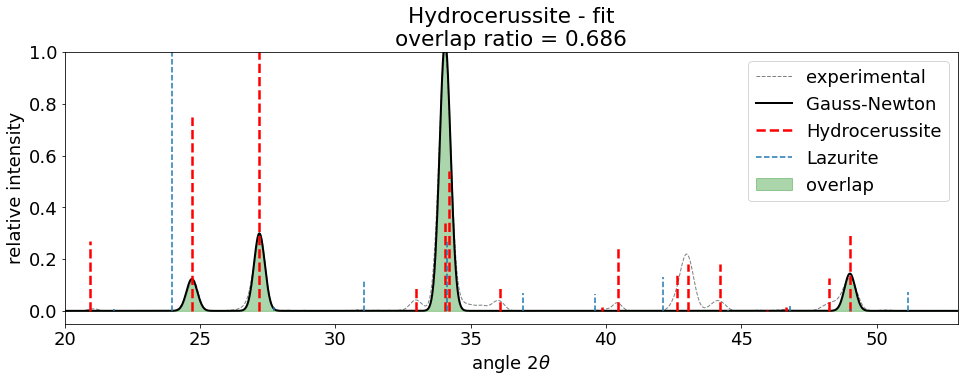

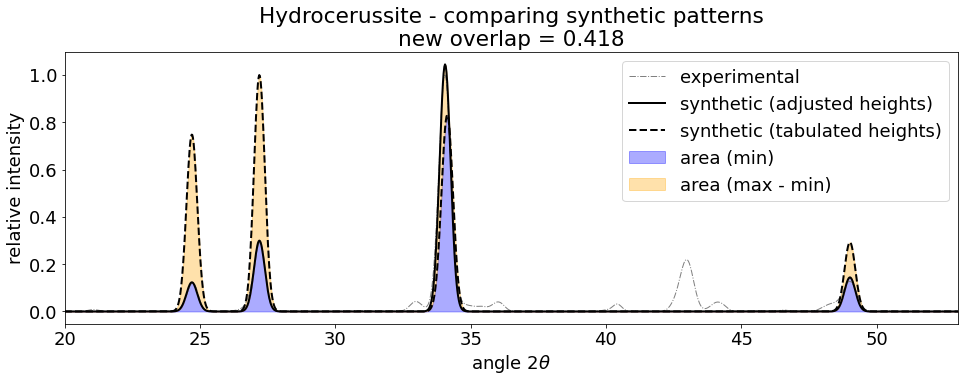

In [11]:
rcParams['font.size'] = 18

phase_check = database['Hydrocerussite'][0]

phase_comparison = database['Lazurite'][0]
#phase_comparison = None

adjust_calibration = True
phase_calibration = database['Hydrocerussite'][0]

### Fit ###

spectrum_calibration = FastSpectraXRD().from_components(
    opt = calib.opt.copy(),
    counts = data_count_smoothed,
    rescaling = data_rescaling,
    intensity = data_count_smoothed / nanmax(data_count_smoothed)
)

if adjust_calibration:
    gn_calibration = GaussNewton(phase_calibration, spectrum, min_theta = min_theta, max_theta = max_theta,
                                 min_intensity = min_intensity, first_n_peaks = first_n_peaks, sigma = sigma)
    gn_calibration.fit_cycle(gamma = True, steps = 16).fit_cycle(a = True, s = True, gamma = True, steps = 16)
    spectrum_calibration.opt = gn_calibration.opt.copy()

gn = GaussNewton(phase_check, spectrum_calibration, min_theta = min_theta, max_theta = max_theta,
                 min_intensity = min_intensity, first_n_peaks = first_n_peaks, sigma = sigma)
gn.fit_cycle(gamma = True, steps = 10)

z_min = minimum(gn.z(), gn.z0())
z_max = maximum(gn.z(), gn.z0())
z_diff = abs(z_min - z_max)
overlap = z_min.sum() / z_max.sum()

### Plot ###

fig, ax = subplots(figsize = (16, 5))
sca(ax)
gn.plot_spectrum(c = 'grey', ls = '--', lw = 1, label = 'experimental')
gn.plot(c = 'black', ls = '-', lw = 2, label = 'Gauss-Newton')
gn.phase.plot(lw = 2.5, alpha = 1)
if phase_comparison is not None:
    phase_comparison.plot(color = 'tab:blue')
ax.fill_between(gn.theta, gn.overlap(), color = 'g', alpha = 0.33, label = 'overlap')
ax.legend(frameon = True, loc = 'upper right')
ax.set_xlim(min_theta, max_theta)
ax.set_ylim(-0.05, 1)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel('relative intensity')
ax.set_title(f'{gn.label} - fit\noverlap ratio = {gn.overlap3_area_ratio():.3f}')
show()

fig, ax = subplots(figsize = (16, 5))
sca(ax)
gn.plot_spectrum(c = 'grey', ls = '-.', lw = 1, label = 'experimental')
ax.plot(gn.theta, gn.z(), c = 'black', ls = '-', lw = 2, label = 'synthetic (adjusted heights)')
ax.plot(gn.theta, gn.z0(), c = 'black', ls = '--', lw = 2, label = 'synthetic (tabulated heights)')
ax.fill_between(gn.theta, z_min, color = 'blue', alpha = 0.33, label = 'area (min)')
ax.fill_between(gn.theta, z_max, z_min, color = 'orange', alpha = 0.33, label = 'area (max - min)')
ax.legend(frameon = True, loc = 'upper right')
ax.set_xlim(min_theta, max_theta)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel('relative intensity')
ax.set_title(f'{gn.label} - comparing synthetic patterns\nnew overlap = {overlap:.3f}')
show()

### List of phases vs experimental XRD pattern (and save figures)
- `phase_calibration`: phase that will be used to calibrate, if `adjust_calibration` is True

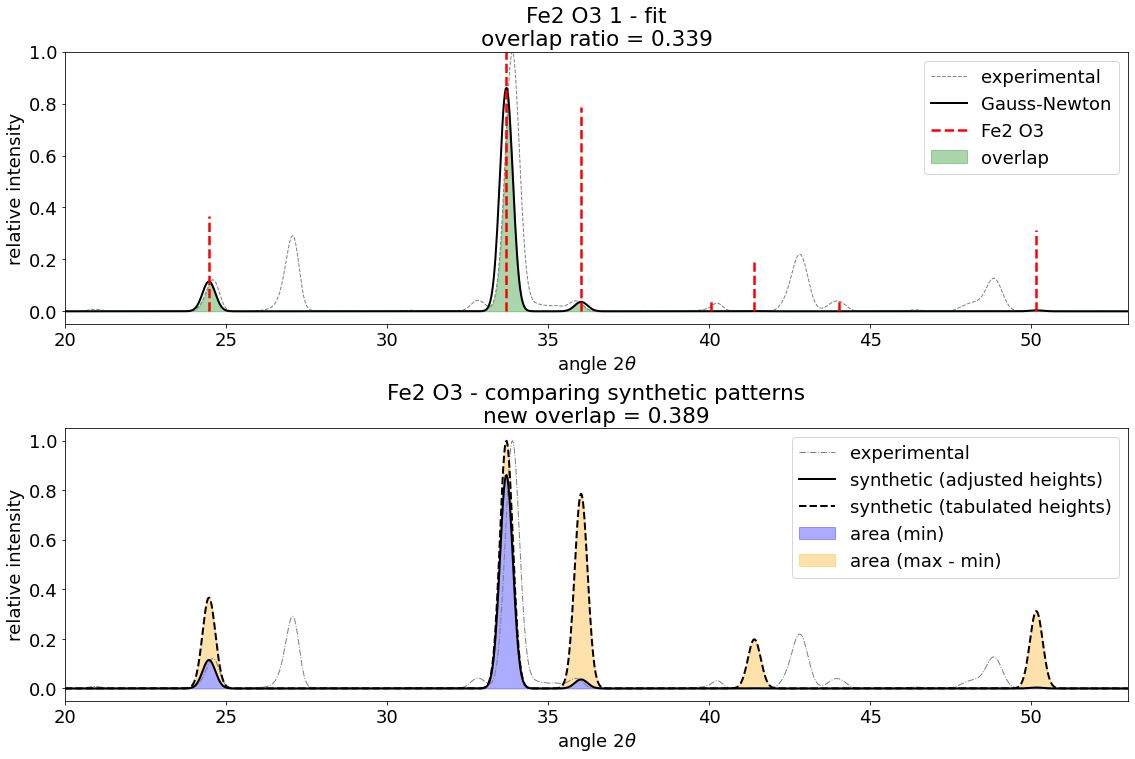

<Figure size 432x288 with 0 Axes>

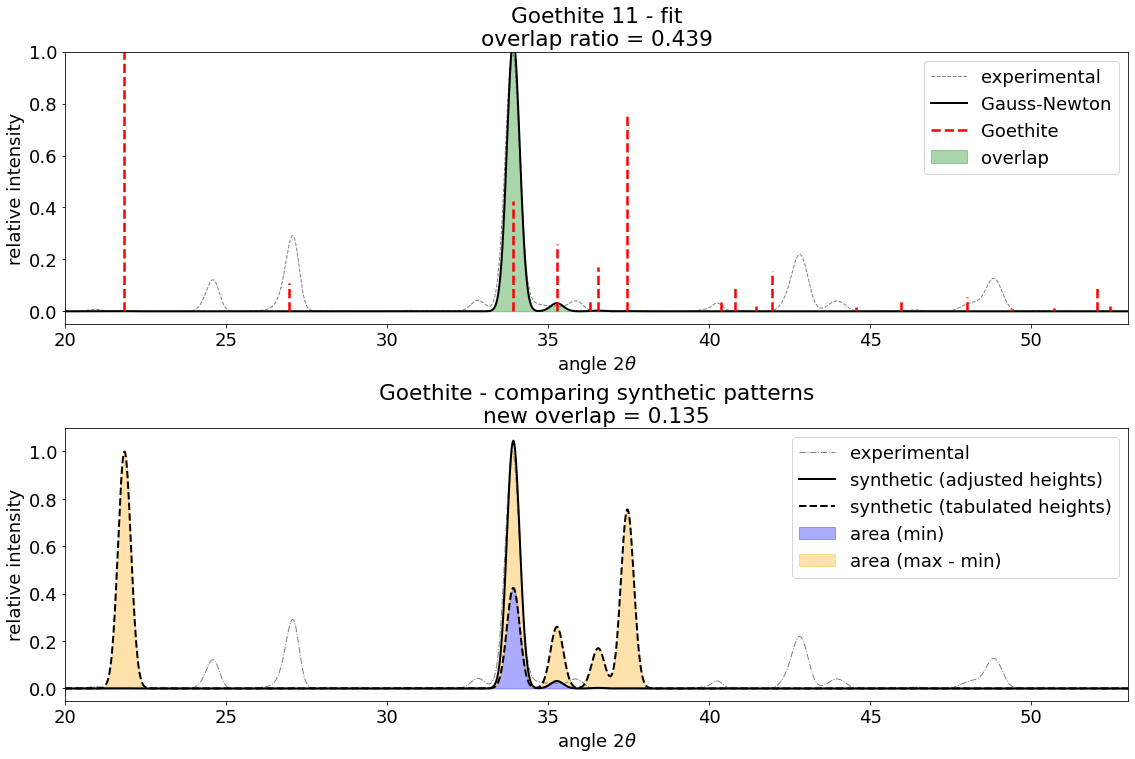

<Figure size 432x288 with 0 Axes>

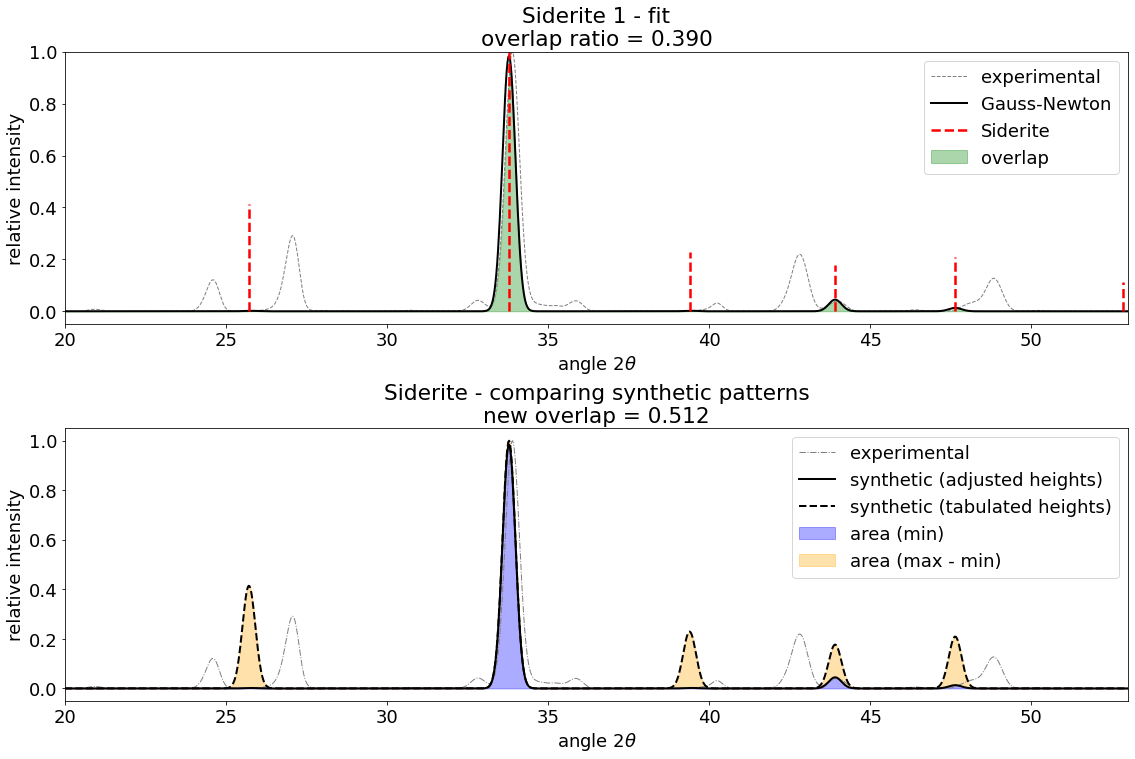

<Figure size 432x288 with 0 Axes>

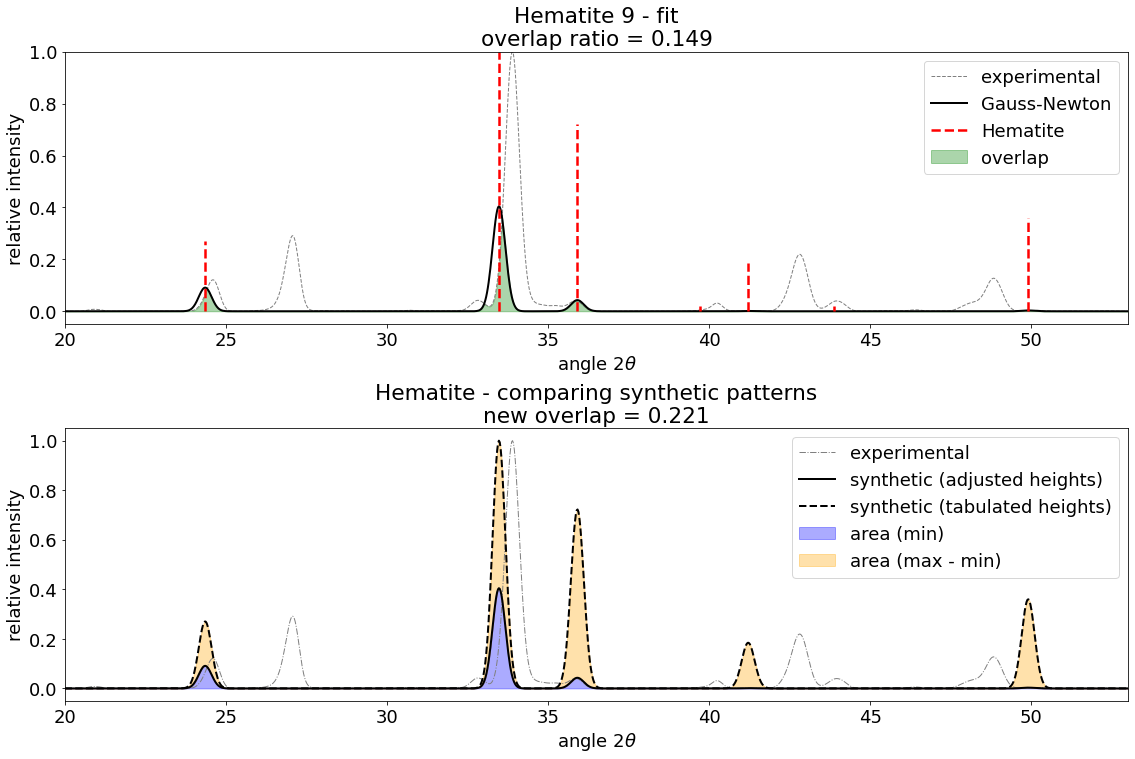

<Figure size 432x288 with 0 Axes>

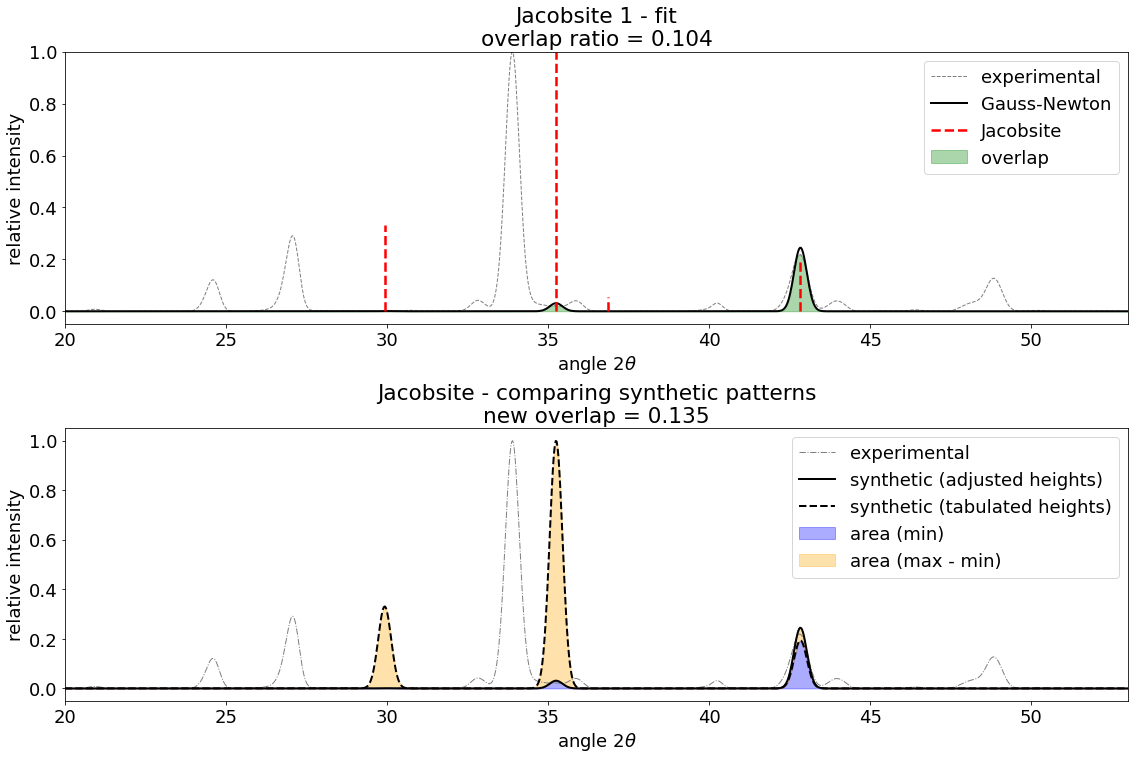

<Figure size 432x288 with 0 Axes>

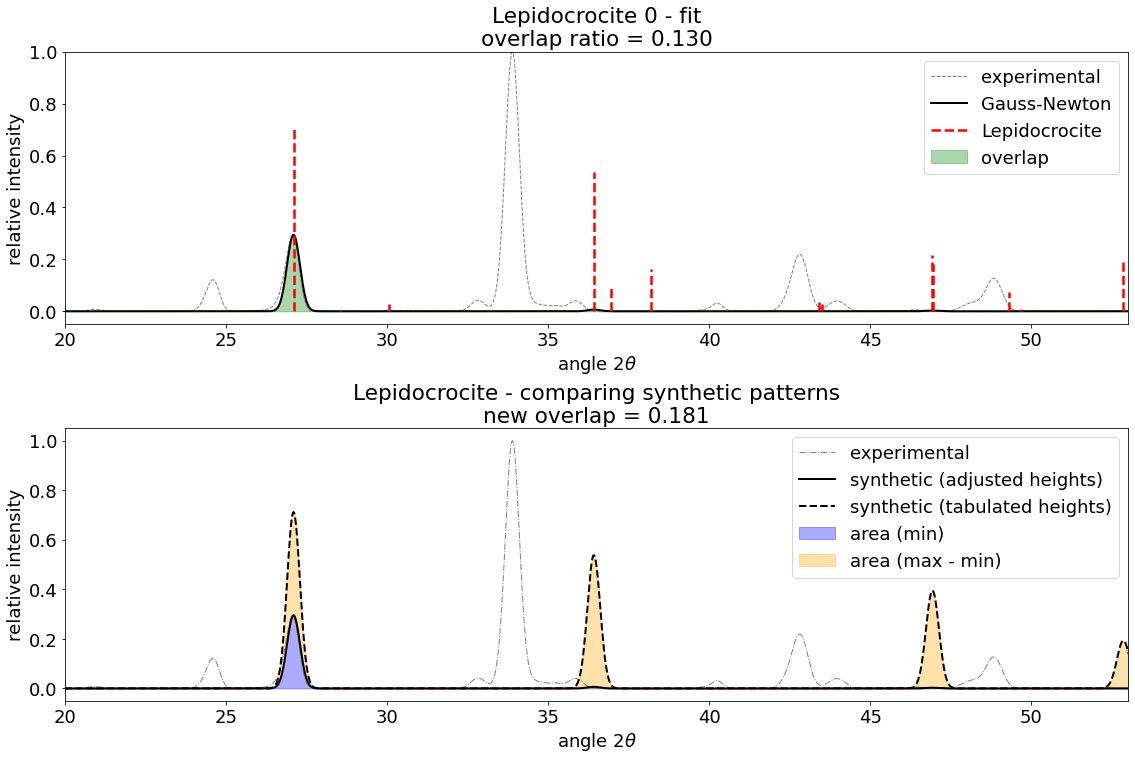

<Figure size 432x288 with 0 Axes>

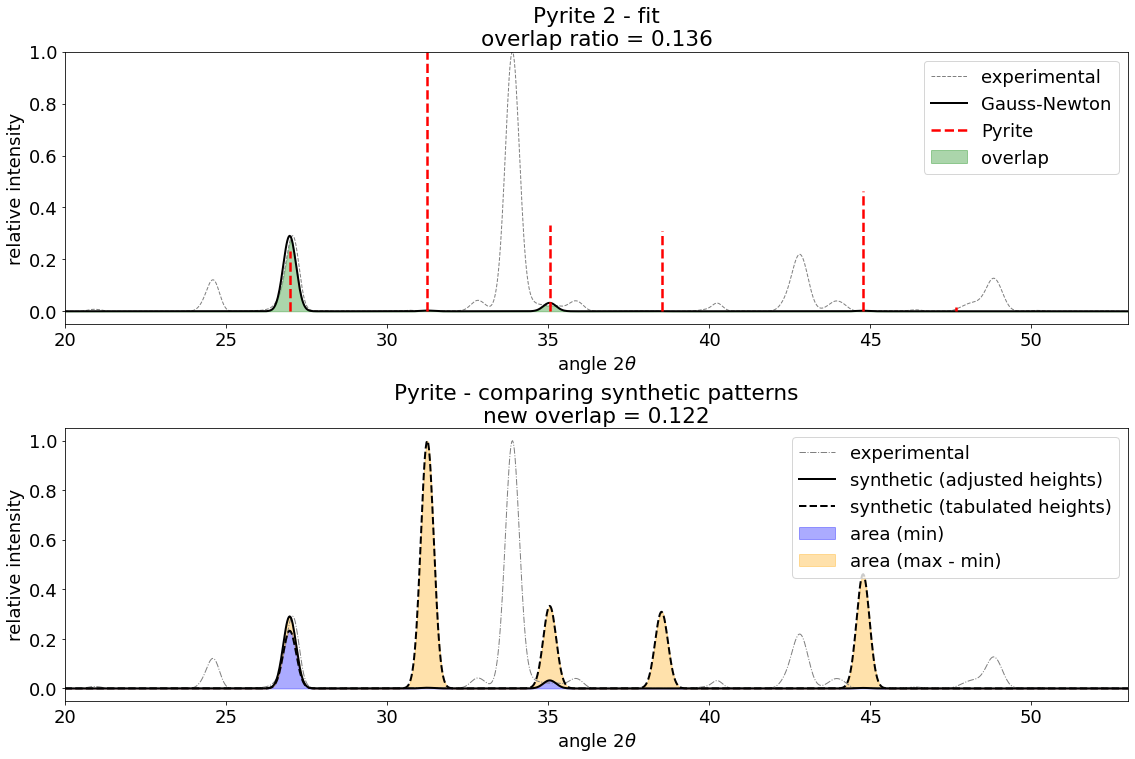

<Figure size 432x288 with 0 Axes>

In [15]:
rcParams['font.size'] = 18

adjust_calibration = False
phase_calibration = database['Hydrocerussite'][0]

###

if not isdir(path_phases_check):
    makedirs(path_phases_check)

for i in range(df_phases_sel.shape[0]):
    
    ### Fit ###
    
    phase_name = df_phases_sel.loc[i, 'Phase']
    phase_sample = df_phases_sel.loc[i, 'Sample']
    phase_check = database[phase_name][phase_sample]
    
    spectrum_calibration = FastSpectraXRD().from_components(
        opt = calib.opt.copy(),
        counts = data_count_smoothed,
        rescaling = data_rescaling,
        intensity = data_count_smoothed / nanmax(data_count_smoothed)
    )

    if adjust_calibration:
        gn_calibration = GaussNewton(phase_calibration, spectrum, min_theta = min_theta, max_theta = max_theta,
                                     min_intensity = min_intensity, first_n_peaks = first_n_peaks, sigma = sigma)
        gn_calibration.fit_cycle(gamma = True, steps = 16).fit_cycle(a = True, s = True, gamma = True, steps = 16)
        spectrum_calibration.opt = gn_calibration.opt.copy()

    gn = GaussNewton(phase_check, spectrum_calibration, min_theta = min_theta, max_theta = max_theta,
                     min_intensity = min_intensity, first_n_peaks = first_n_peaks, sigma = sigma)
    gn.fit_cycle(gamma = True, steps = 10)

    z_min = minimum(gn.z(), gn.z0())
    z_max = maximum(gn.z(), gn.z0())
    z_diff = abs(z_min - z_max)
    overlap = z_min.sum() / z_max.sum()

    ### Plot ###

    fig, axs = subplots(2, 1, figsize = (16, 10))
    fig.tight_layout(h_pad = 4)
    
    ax = axs[0]
    sca(ax)
    gn.plot_spectrum(c = 'grey', ls = '--', lw = 1, label = 'experimental')
    gn.plot(c = 'black', ls = '-', lw = 2, label = 'Gauss-Newton')
    gn.phase.plot(lw = 2.5, alpha = 1)
    ax.fill_between(gn.theta.squeeze(), gn.overlap(), color = 'g', alpha = 0.33, label = 'overlap')
    ax.legend(frameon = True, loc = 'upper right')
    ax.set_xlim(min_theta, max_theta)
    ax.set_ylim(-0.05, 1)
    ax.set_xlabel(r'angle $2\theta$')
    ax.set_ylabel(r'relative intensity')
    ax.set_title(f'{phase_name} {phase_sample} - fit\noverlap ratio = {gn.overlap3_area_ratio():.3f}')
    
    ax = axs[1]
    sca(ax)
    gn.plot_spectrum(c = 'grey', ls = '-.', lw = 1, label = 'experimental')
    ax.plot(gn.theta, gn.z(), c = 'black', ls = '-', lw = 2, label = 'synthetic (adjusted heights)')
    ax.plot(gn.theta, gn.z0(), c = 'black', ls = '--', lw = 2, label = 'synthetic (tabulated heights)')
    ax.fill_between(gn.theta, z_min, color = 'blue', alpha = 0.33, label = 'area (min)')
    ax.fill_between(gn.theta, z_max, z_min, color = 'orange', alpha = 0.33, label = 'area (max - min)')
    ax.legend(frameon = True, loc = 'upper right')
    ax.set_xlim(min_theta, max_theta)
    ax.set_xlabel(r'angle $2\theta$')
    ax.set_ylabel('relative intensity')
    ax.set_title(f'{gn.label} - comparing synthetic patterns\nnew overlap = {overlap:.3f}')
    
    show()
    for c in ['/', '\\']:
        phase_name = phase_name.replace(c, '_')
    savefig(f'{path_phases_check}{phase_name} check_fit.png', bbox_inches = 'tight', dpi = 300)
    close(fig)